In [ ]:
%pip install scipy 

In [18]:
import simpy
import random
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [30]:
# Simulation Parameters:
NUM_TRUCKS = 20
NUM_CHARGERS = 200
NUM_TESTERS = 35
TOTAL_NUM_BATTERY = 3000 
BATCH_SIZE = 20
TEST_TIME = 0
TRANSFER_TIME = 1  # Time taken to transfer a batch to the chargers
EXPECTED_SERVICE_TIME = 8*60  # Expected time on road for each battery

back_up_rate = 0.45

MAX_INVENTORY = [40, 60, 80, 100, 120, 140, 160]
NUM_SWAPPING_STATIONS = len(MAX_INVENTORY)
TRUCK_CAPACITY = max(MAX_INVENTORY)

# Global Counters and Indexes
global_battery_index = 0 
stage_1_cnt = 0
stage_2_cnt = 0

# Indicator
request_indicator = [0] * len(MAX_INVENTORY)

# Buffers 
test_buffer = None
fully_charged_buffer = None
road_buffer = None
truck_buffer = None



# Logs
road_counts_over_time = []

bss_queue_over_times = [] 
bss_server_over_times = [] 
swapping_stations_counts_over_time = []   
station_inventory_counts_over_time = [] 
db_buffer_over_time = []

test_queue_over_time = []
ccs_queue_over_times = [] 
stage_counts_over_time = []
fb_buffer_over_time = []  # for fully charged buffer


def initialize_charging_station(env):
    global global_battery_index, batch_queue, test_buffer, ccs_queue_over_times, fb_buffer_over_time
    global test_queue_over_time
    for _ in range(int(TOTAL_NUM_BATTERY * back_up_rate- sum(MAX_INVENTORY))):
        global_battery_index += 1
        battery = Battery(global_battery_index)
        fully_charged_buffer.put(battery)

    for _ in range(int(TOTAL_NUM_BATTERY * back_up_rate/2- sum(MAX_INVENTORY)/2)):
        global_battery_index += 1
        battery = Battery(global_battery_index)
        test_buffer.put(battery)
    
    print(f"Stopped supplying as total supplied batteries reached {TOTAL_NUM_BATTERY}")

    while True:
        if len(test_buffer.items) > 0 :
            while len(test_buffer.items) > 0 :
                battery = yield test_buffer.get()
                yield env.process(battery.test_and_transfer(env, testers, batch_queue)) 
                # print("tested")
        else:
            yield env.timeout(1)

        test_queue_over_time.append((env.now, len(testers.queue)))
        fb_buffer_over_time.append((env.now, len(fully_charged_buffer.items))) 
        ccs_queue_over_times.append((env.now, len(chargers.queue)))
         
def initialize_inventories(env):
    global global_battery_index, bss_queue_over_times, bss_server_over_times, swapping_stations_counts_over_time
    for station_index, max_inventory in enumerate(MAX_INVENTORY):
        for _ in range(max_inventory):
            battery = Battery(global_battery_index)
            yield swapping_station_inventory[station_index].put(battery) 
            
    swapping_stations_counts_over_time.append((env.now, [len(station.queue) + station.count for station in swapping_stations]))
    bss_queue_over_times.append((env.now, [len(station.queue)  for station in swapping_stations]))
    bss_server_over_times.append((env.now, [ station.count for station in swapping_stations]))
 
def road_process(env):
    global road_buffer, road_counts_over_time, global_battery_index, swapping_stations_counts_over_time
    global bss_queue_over_times, bss_server_over_times, request_indicator
    initialized_batteries = 0
    while initialized_batteries < int(TOTAL_NUM_BATTERY * (1 - back_up_rate)) :  
        battery = Battery(global_battery_index)
        yield road_buffer.put(battery)
        initialized_batteries += 1
        global_battery_index += 1
        
    road_counts_over_time.append((env.now, len(road_buffer.items)))  # Log data after adding a battery

    # Calculate total capacity and probabilities for each station
    total_capacity = sum(MAX_INVENTORY)
    station_probabilities = [cap / total_capacity for cap in MAX_INVENTORY]

    # Process of swapping batteries on the road
    while True:
        if len(road_buffer.items) > 0: 
            num_of_battery_on_road = len(road_buffer.items) 
            
            # Wait for the next battery selection
            yield env.timeout(random.expovariate(num_of_battery_on_road / EXPECTED_SERVICE_TIME))
    
            # Discharge and select a swapping station for the first battery in the buffer
            battery_to_swap =  yield road_buffer.get()  
            chosen_station = random.choices(range(NUM_SWAPPING_STATIONS), weights=station_probabilities, k=1)[0]
 
            yield env.process(battery_to_swap.swap(env, chosen_station))

            if len(swapping_station_inventory[chosen_station].items) <= MAX_INVENTORY[chosen_station] * 0.4 and not (request_indicator[chosen_station]):
                request_indicator[chosen_station] = 1
                yield env.process(request_truck(env, chosen_station)) 
                request_indicator[chosen_station] = 0

            
            # Add the swapped battery to the station's container
            yield swapped_battery_containers[chosen_station].put(battery_to_swap)
            print(f"{battery_to_swap.name} added to the container at Station {chosen_station} at {env.now}")
            db_buffer_over_time.append((env.now, [len(container.items) for container in swapped_battery_containers]))
     
            swapping_stations_counts_over_time.append((env.now, [len(station.queue) + station.count for station in swapping_stations]))
            station_inventory_counts_over_time.append((env.now, chosen_station, len(swapping_station_inventory[chosen_station].items)))
  
            road_counts_over_time.append((env.now, len(road_buffer.items)))
            swapping_stations_counts_over_time.append((env.now, [len(station.queue) + station.count for station in swapping_stations]))
            bss_queue_over_times.append((env.now, [len(station.queue)  for station in swapping_stations]))
            bss_server_over_times.append((env.now, [ station.count for station in swapping_stations]))

        
        else:
            yield env.timeout(1)
     


class Battery:
    def __init__(self, idx):
        global global_battery_index
        self.name = f"Battery {idx}"
        global_battery_index += 1

    def swap(self, env, station_index): 
        global road_buffer, road_counts_over_time, swapping_stations_counts_over_time
        global db_buffer_over_time, swapping_station_inventory, truck_buffer
        global station_inventory_counts_over_time
 
        while not len(swapping_station_inventory[station_index].items) > 0.9:
            yield env.timeout(1)  

        with swapping_stations[station_index].request() as req:
            yield req
            released_battery = yield swapping_station_inventory[station_index].get()
            yield road_buffer.put(released_battery)
            print(f"{released_battery.name} released to the road from Station {station_index} at {env.now}")
            
            road_counts_over_time.append((env.now, len(road_buffer.items)))
            swapping_stations_counts_over_time.append((env.now, [len(station.queue) + station.count for station in swapping_stations]))
            station_inventory_counts_over_time.append((env.now, station_index, len(swapping_station_inventory[station_index].items)))
    
   

            print(f"{self.name} starts swapping at Station {station_index} at {env.now}")
            yield env.timeout(5)  # Fixed swapping time
            print(f"{self.name} ends swapping at Station {station_index} at {env.now}")
  

    def test_and_transfer(self, env, testers, batch_queue):
        global test_queue_over_time , TEST_TIME

        with testers.request() as test_req:
            yield test_req
            print(f'{self.name} starts testing at {env.now}')
            yield env.timeout(TEST_TIME)
            # yield env.timeout(random.randint(1, 2))  # Testing time between 1 and 2
            test_queue_over_time.append((env.now, len(testers.queue)))
            print(f'{self.name} ends testing at {env.now}')
  
        yield batch_queue.put(self)

    def charge(self, env, chargers):
        # Battery charging process
        global stage_1_cnt, stage_2_cnt, stage_counts_over_time, ccs_queue_over_times, fully_charged_buffer, fb_buffer_over_time

        print(f'{self.name} arrives for charging at {env.now}')
        ccs_queue_over_times.append((env.now, len(chargers.queue)))
        with chargers.request() as req:   # 
            
            yield req

            # Constant-current phase
            start_cc_service = env.now
            print(f'{self.name} starts constant-current charging at {start_cc_service}')
            cc_charging_time = random.randint(30, 120) # Gamma() powerfamily distri
            stage_1_cnt += 1
            stage_counts_over_time.append((env.now, stage_1_cnt, stage_2_cnt, stage_1_cnt + stage_2_cnt))
            yield env.timeout(cc_charging_time)
            stage_1_cnt -= 1
            stage_counts_over_time.append((env.now, stage_1_cnt, stage_2_cnt, stage_1_cnt + stage_2_cnt))
            print(f'{self.name} ends constant-current charging at {env.now}')
            yield env.timeout(1)  # Small delay before starting CV stage

            # Constant-voltage phase
            start_cv_service = env.now
            print(f'{self.name} starts constant-voltage charging at {start_cv_service}')
            cv_charging_time = random.randint(20, 40)
            stage_2_cnt += 1
            stage_counts_over_time.append((env.now, stage_1_cnt, stage_2_cnt, stage_1_cnt + stage_2_cnt))
            yield env.timeout(cv_charging_time)
            stage_2_cnt -= 1
            stage_counts_over_time.append((env.now, stage_1_cnt, stage_2_cnt, stage_1_cnt + stage_2_cnt))
            print(f'{self.name} ends constant-voltage charging at {env.now}')

        yield fully_charged_buffer.put(self)
        ccs_queue_over_times.append((env.now, len(chargers.queue)))
        fb_buffer_over_time.append((env.now, len(fully_charged_buffer.items)))
        print(f'{self.name} stored in the fully charged buffer at {env.now}')

def battery_transfer_warehouse(env, batch_queue, chargers, transfer_time):
    while True:
        batch = []
        while len(batch) < BATCH_SIZE:
            battery = yield batch_queue.get()
            batch.append(battery)

        yield env.timeout(transfer_time)

        for battery in batch:
            env.process(battery.charge(env, chargers))
 
def request_truck(env, station_index):
    global station_inventory_counts_over_time, test_buffer
    global truck_buffer, fully_charged_buffer, swapped_battery_containers, batch_queue


    while len(fully_charged_buffer.items) <=  0.9:
        env.timeout(1)
        
    with truck_buffer.request() as request:
        yield request
        truck_carrier_fb = []
        truck_carrier_db = []

        # Load batteries from fully charged buffer
        for _ in range(TRUCK_CAPACITY):
            if len(fully_charged_buffer.items) > 0.9:
                battery = yield fully_charged_buffer.get()  # Use get instead of pop
                truck_carrier_fb.append(battery)
                # print(f"Loaded {battery.name} from fully charged buffer onto truck at time {env.now}")
        print("oh")
        print(f'Truck successfully loaded {len(truck_carrier_fb)} fbs at time {env.now}')

        print(f'Truck heading to Station {station_index} at time {env.now}')
        yield env.timeout(random.randint(10, 15))
        
        print(f'Truck arrive at Station {station_index} at time {env.now}')
 
        station_inventory_counts_over_time.append((env.now, station_index, len(swapping_station_inventory[station_index].items)))

        # Load used batteries for testing
        print(-1)
        print(MAX_INVENTORY[station_index] - len( swapping_station_inventory[station_index].items))
        for idx in range(MAX_INVENTORY[station_index] - len( swapping_station_inventory[station_index].items) ):
            if truck_carrier_fb: 
                # print(len(truck_carrier_db))
                fb = truck_carrier_fb.pop()
                yield swapping_station_inventory[station_index].put(fb)  # Use put to add the battery back
                db = yield swapped_battery_containers[station_index].get()  # Use get to remove a battery
                truck_carrier_db.append(db)

                yield test_buffer.put(db)
                # print(f'drain battery {db.name} loaded to the truck from Station {station_index} at time {env.now}')
                print(len(truck_carrier_db))
            else:
                print("sdfsdfsd")
                
        # print(f'Truck successfully loaded {len(truck_carrier_db)} dbs at time {env.now}') 
        station_inventory_counts_over_time.append((env.now, station_index, len(swapping_station_inventory[station_index].items)))
        print("hi")
        yield env.timeout(random.randint(10, 15))
        print(f"Truck returning from Station {station_index} at time {env.now}")
        while len(truck_carrier_db) > 0: 
            print("hello")
            db = truck_carrier_db.pop()
            # yield test_buffer.put(db)
        

 
env = simpy.Environment()
testers = simpy.Resource(env, capacity=NUM_TESTERS)
chargers = simpy.Resource(env, capacity=NUM_CHARGERS)
batch_queue = simpy.Store(env)
fully_charged_buffer = simpy.Store(env)
test_buffer = simpy.Store(env)
road_buffer = simpy.Store(env)
swapping_stations = [simpy.Resource(env, capacity=1) for i in range(NUM_SWAPPING_STATIONS)]
swapped_battery_containers = [simpy.Store(env, capacity=sum(MAX_INVENTORY)) for i in range(NUM_SWAPPING_STATIONS)]
swapping_station_inventory = [simpy.Store(env, capacity=MAX_INVENTORY[i]) for i in range(NUM_SWAPPING_STATIONS)]
truck_buffer = simpy.Resource(env, capacity=NUM_TRUCKS)

env.process(initialize_inventories(env))
env.process(initialize_charging_station(env))
env.process(battery_transfer_warehouse(env, batch_queue, chargers, TRANSFER_TIME))
env.process(road_process(env))


# env.run(until=5*24*60)
env.run(until=1000)
 
 

Stopped supplying as total supplied batteries reached 3000
Battery 1302 starts testing at 0
Battery 1302 ends testing at 0
Battery 1304 starts testing at 0
Battery 1304 ends testing at 0
Battery 1306 starts testing at 0
Battery 1306 ends testing at 0
Battery 1308 starts testing at 0
Battery 1308 ends testing at 0
Battery 1310 starts testing at 0
Battery 1310 ends testing at 0
Battery 1312 starts testing at 0
Battery 1312 ends testing at 0
Battery 1314 starts testing at 0
Battery 1314 ends testing at 0
Battery 1316 starts testing at 0
Battery 1316 ends testing at 0
Battery 1318 starts testing at 0
Battery 1318 ends testing at 0
Battery 1320 starts testing at 0
Battery 1320 ends testing at 0
Battery 1322 starts testing at 0
Battery 1322 ends testing at 0
Battery 1324 starts testing at 0
Battery 1324 ends testing at 0
Battery 1326 starts testing at 0
Battery 1326 ends testing at 0
Battery 1328 starts testing at 0
Battery 1328 ends testing at 0
Battery 1330 starts testing at 0
Battery 1330

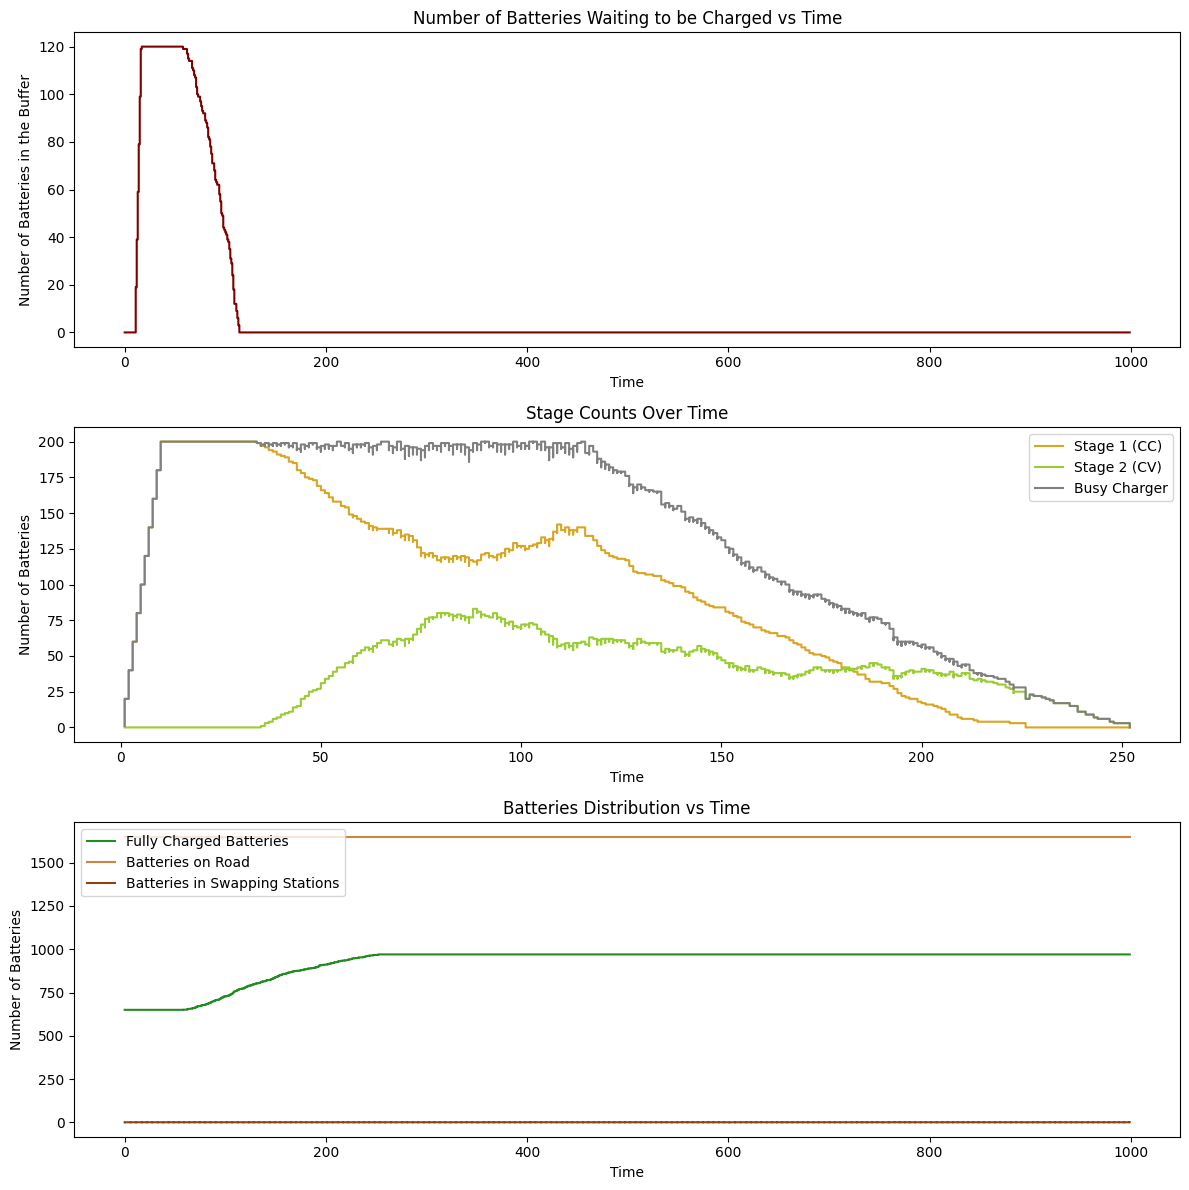

In [31]:
def plot_times(times, title):
    times.sort(key=lambda x: x[0])  # Sort by time
    plt.step(*zip(*times), where='post', color = 'maroon')
    plt.xlabel('Time')
    plt.ylabel('Number of Batteries in the Buffer')
    plt.title(title)

def plot_stage_counts(stage_counts, title):
    times, stage_1_counts, stage_2_counts, charger_counts = zip(*stage_counts)
    plt.step(times, stage_1_counts, where='post', label='Stage 1 (CC)', color = 'goldenrod')
    plt.step(times, stage_2_counts, where='post', label='Stage 2 (CV)', color = 'yellowgreen') 
    plt.step(times, charger_counts, where='post', label='Busy Charger', color = 'gray')
    plt.xlabel('Time')
    plt.ylabel('Number of Batteries')
    plt.title(title)
    plt.legend()

def plot_battery_distribution(fb_buffer_over_time, road_counts, station_counts_over_time, title):
    times, fb_buffer_over_time = zip(*fb_buffer_over_time)
    plt.step(times, fb_buffer_over_time, where='post', label='Fully Charged Batteries', color = 'forestgreen')

    times, road_counts = zip(*road_counts)
    plt.step(times, road_counts, where='post', label='Batteries on Road', color='peru')

    times, total_counts = zip(*[(time, sum(counts)) for time, counts in station_counts_over_time])
    plt.step(times, total_counts, where='post', label='Batteries in Swapping Stations', color='saddlebrown')

    
    plt.xlabel('Time')
    plt.ylabel('Number of Batteries')
    plt.title(title)
    plt.legend()



 
plt.figure(figsize=(12, 12))  

plt.subplot(3, 1, 1)  
plot_times(ccs_queue_over_times, 'Number of Batteries Waiting to be Charged vs Time')

plt.subplot(3, 1, 2)  
plot_stage_counts(stage_counts_over_time, 'Stage Counts Over Time')


plt.subplot(3, 1, 3)   
plot_battery_distribution(fb_buffer_over_time, road_counts_over_time, swapping_stations_counts_over_time, 'Batteries Distribution vs Time') 

plt.tight_layout()
plt.show()  

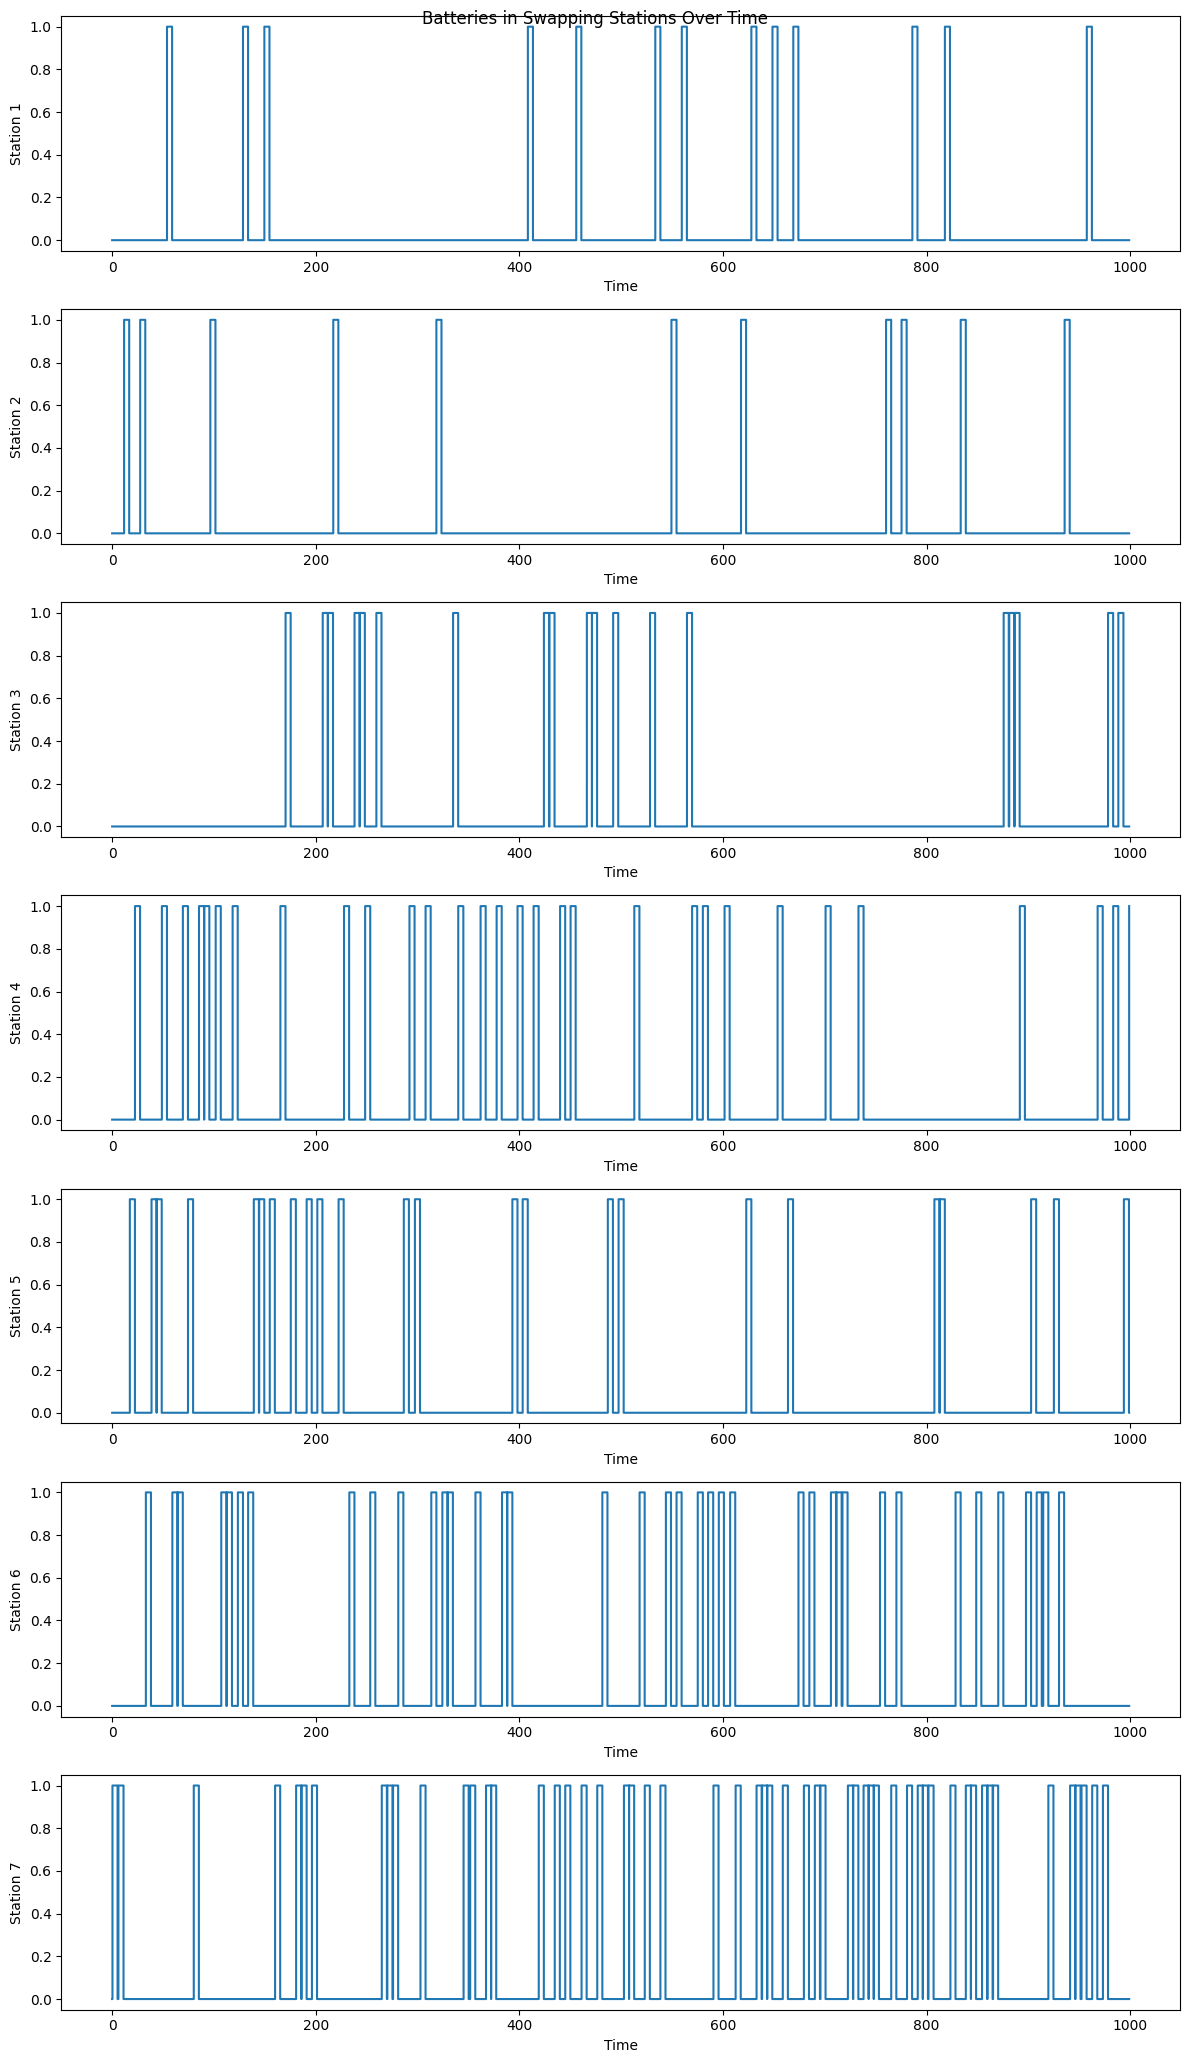

In [32]:
def plot_swapping_station_counts(station_counts_over_time, title):
    num_stations = len(station_counts_over_time[0][1])  # Assuming all entries have the same number of stations

    # Create a separate subplot for each station
    fig, axes = plt.subplots(num_stations, 1, figsize=(12, num_stations * 3))  # Adjust the size as needed
    fig.suptitle(title)

    for station_index in range(num_stations):
        times, counts = zip(*[(time, counts[station_index]) for time, counts in station_counts_over_time])
        # print(sum(counts))
        ax = axes[station_index] if num_stations > 1 else axes
        ax.step(times, counts, where='post')
        ax.set_ylabel(f'Station {station_index + 1}')
        ax.set_xlabel('Time')
    plt.tight_layout()
    plt.show()


plot_swapping_station_counts(swapping_stations_counts_over_time, 'Batteries in Swapping Stations Over Time')


In [33]:
test_queue_over_time

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 

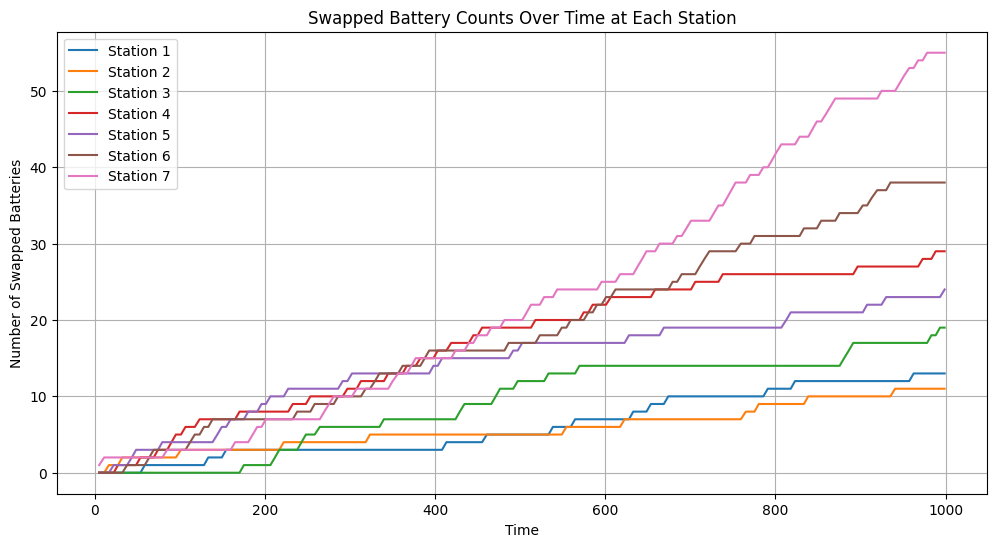

In [34]:
import matplotlib.pyplot as plt

def plot_swapped_battery_counts(db_buffer_over_time, title):
    num_stations = len(db_buffer_over_time[0][1])  # Assuming all entries have the same number of stations
     
    times, station_counts = zip(*db_buffer_over_time)
     
    plt.figure(figsize=(12, 6))
    for station_index in range(num_stations):
        counts = [count[station_index] for count in station_counts]
        plt.plot(times, counts, label=f'Station {station_index + 1}')
     
    plt.xlabel('Time')
    plt.ylabel('Number of Swapped Batteries')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
 
plot_swapped_battery_counts(db_buffer_over_time, "Swapped Battery Counts Over Time at Each Station")


In [35]:
# def unique_consecutive(data, key=lambda x: x):
#     """
#     Yields unique consecutive elements from 'data' based on the 'key' function.
#     """
#     iterator = iter(data)
#     last_item = next(iterator)
#     yield last_item
#     for item in iterator:
#         if key(item) != key(last_item):
#             yield item
#             last_item = item

# for idx in range(5):

#     # Filter out consecutive duplicates
#     unique_data = list(unique_consecutive(swapping_stations_counts_over_time, key=lambda x: x[1][idx]))
    
#     # Now, zip the times and counts for the specific station index
#     times, counts = zip(*[(time, counts[station_index]) for time, counts in unique_data])
#     print(sum(counts))

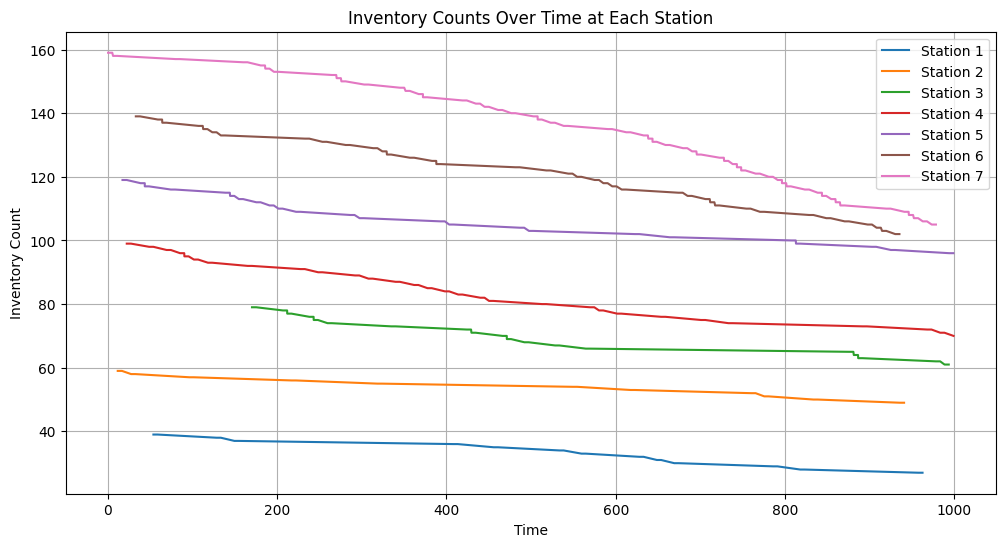

In [36]:
def plot_station_inventory_counts(station_inventory_counts_over_time, title): 
    num_stations = max(station_inventory_counts_over_time, key=lambda x: x[1])[1] + 1
 
    times = [entry[0] for entry in station_inventory_counts_over_time]
    station_counts = [[] for _ in range(num_stations)]
    for time, station_index, count in station_inventory_counts_over_time:
        station_counts[station_index].append((time, count))
 
    plt.figure(figsize=(12, 6))
    for station_index in range(num_stations):
        station_times, counts = zip(*station_counts[station_index])
        plt.plot(station_times, counts, label=f'Station {station_index + 1}')
     
    plt.xlabel('Time')
    plt.ylabel('Inventory Count')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
plot_station_inventory_counts(station_inventory_counts_over_time, "Inventory Counts Over Time at Each Station")